---
title: "Pan-UKB Principal Components v01"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-12-08"
file-modified: "2023-12-08"
abstract: "We look at the first few principal components of the low rank matrix obtained by applying our method on the z-scores of Pan-UKB summary statistics."

---

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import simulate as mpy_simulate

# Read Data and Results

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/nnwmf"
zscore_filename = f"{data_dir}/GWAS_Zscore.tsv"
trait_filename = f"{data_dir}/trait_manifest_TableS6_no_readme.tsv"
zscore_df = pd.read_csv(zscore_filename, sep = '\t')
trait_df = pd.read_csv(trait_filename, sep = '\t')

# remove extra columns from trait_df

colnames = trait_df.columns.tolist()
colnames[0] = "zindex"
trait_df.columns = colnames
trait_df_mod = trait_df.drop(labels = ['coding', 'modifier', 'coding_description', 'filename', 'aws_link'], axis=1)
trait_df_mod

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
0,1,icd10,A04,both_sexes,A04 Other bacterial intestinal infections,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,3088,417443.0,420531,6130.649032,0.0033
1,2,icd10,A08,both_sexes,A08 Viral and other specified intestinal infec...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,1107,419424.0,420531,2208.171897,0.0001
2,3,icd10,A09,both_sexes,A09 Diarrhoea and gastro-enteritis of presumed...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,9029,411502.0,420531,17670.286180,0.0035
3,4,icd10,A41,both_sexes,A41 Other septicaemia,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,5512,415019.0,420531,10879.505810,0.0011
4,5,icd10,B34,both_sexes,B34 Viral infection of unspecified site,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,2129,418402.0,420531,4236.443249,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,2479,continuous,Smoking,both_sexes,"Smoking status, ever vs never",Ever (previous + current smoker) vs never base...,NaN,QT,418817,NaN,418817,418817.000000,0.1100
2479,2480,continuous,eGFR,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) using t...,NaN,QT,401867,NaN,401867,401867.000000,0.2070
2480,2481,continuous,eGFRcreacys,both_sexes,"Estimated glomerular filtration rate, cystain C",eGFR based on cystain C (30720) using the CKD-...,NaN,QT,401570,NaN,401570,401570.000000,0.2380
2481,2482,continuous,eGFRcys,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) and cys...,NaN,QT,402031,NaN,402031,402031.000000,0.2240


In [3]:
#| code-fold: false

zscore_df

,rsid,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z2474,z2475,z2476,z2477,z2478,z2479,z2480,z2481,z2482,z2483
0,rs6657440,-0.903532,0.561842,0.711068,-0.109174,0.223668,-1.728199,0.374988,-0.265971,-2.823282,...,1.521092,0.612532,1.405428,0.018029,0.895337,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,rs7418179,0.398166,1.163539,0.512118,0.144794,-1.313903,-1.547410,0.450270,0.560324,-1.502268,...,-0.296537,-0.734266,-0.093081,0.412077,1.961159,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,rs80125161,-1.739115,-0.172328,0.349145,-0.329335,-0.870640,-1.004155,1.128148,0.151244,-1.816075,...,2.222433,1.092969,2.328233,1.160767,0.909524,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,rs7524174,-0.884478,-1.762000,1.312823,-0.550764,2.132540,0.519828,0.834194,0.699441,-0.885281,...,3.356354,1.990588,3.092179,-0.133810,-0.072845,-1.376310,1.317044,0.913491,0.535188,2.245657
4,rs3829740,-1.469931,-0.519628,-0.281605,-0.267729,-1.060167,0.058116,-0.638319,-0.589767,0.228514,...,-0.320075,-0.128047,-0.524757,-0.232900,-1.051020,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,rs9616937,-0.211947,1.371231,-1.800776,0.609980,-0.619822,0.947269,-1.166021,0.478601,-0.359714,...,0.714167,0.354347,0.611158,-0.354725,1.073043,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,rs1024374,0.027097,-1.817082,0.530216,0.813498,-0.076514,0.784427,1.411160,-1.111740,-0.224438,...,1.107098,1.482684,1.512723,0.322355,-0.374603,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,rs144480800,0.545682,0.391830,0.520505,-1.280976,0.453876,-1.388940,0.025094,0.737788,1.178641,...,-0.562063,-1.148515,-0.994185,-0.268232,-0.069619,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,rs5770994,1.441851,1.152368,-1.500000,-0.468137,-0.444156,-0.780139,-0.853550,-0.316097,0.311219,...,-1.185702,-0.624073,-0.859522,0.549669,1.809912,0.268733,0.947441,1.533302,1.658537,2.218653


In [4]:
X_nan = np.array(zscore_df.loc[:, zscore_df.columns!='rsid']).T
X_nan_cent = X_nan - np.nanmean(X_nan, axis = 0, keepdims = True)
X_nan_mask = np.isnan(X_nan)
X_cent = np.nan_to_num(X_nan_cent, copy = True, nan = 0.0)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(X_nan_mask) / np.prod(X_cent.shape):.3f}")

We have 2483 samples (phenotypes) and 51399 features (variants)
Fraction of Nan entries: 0.000


In [17]:
mf_methods = ['ialm', 'nnm_sparse', 'tsvd']

method_prefix = {
    'ialm' : 'ialm_maxiter10000_admm',
    'nnm_sparse' : 'nnm_sparse_maxiter1000'
}

method_names = {
    'tsvd' : 'Raw Data',
    'ialm' : 'Robust PCA',
    'nnm'  : 'NNM',
    'nnm_weighted' : 'NNM-Weighted',
    'nnm_sparse' : 'NNM-Sparse',
}

with open (f"{result_dir}/{method_prefix['ialm']}_progress.pkl", 'rb') as handle:
    ialm = pickle.load(handle)
    
with open (f"{result_dir}/{method_prefix['nnm_sparse']}_progress.pkl", 'rb') as handle:
    nnm_sparse = pickle.load(handle)

# Convergence of low rank approximations

In the following two figures, @fig-ialm-convergence and @fig-nnmfw-sparse-convergence,
we look at the convergence properties of the different methods on the Pan-UKB dataset.

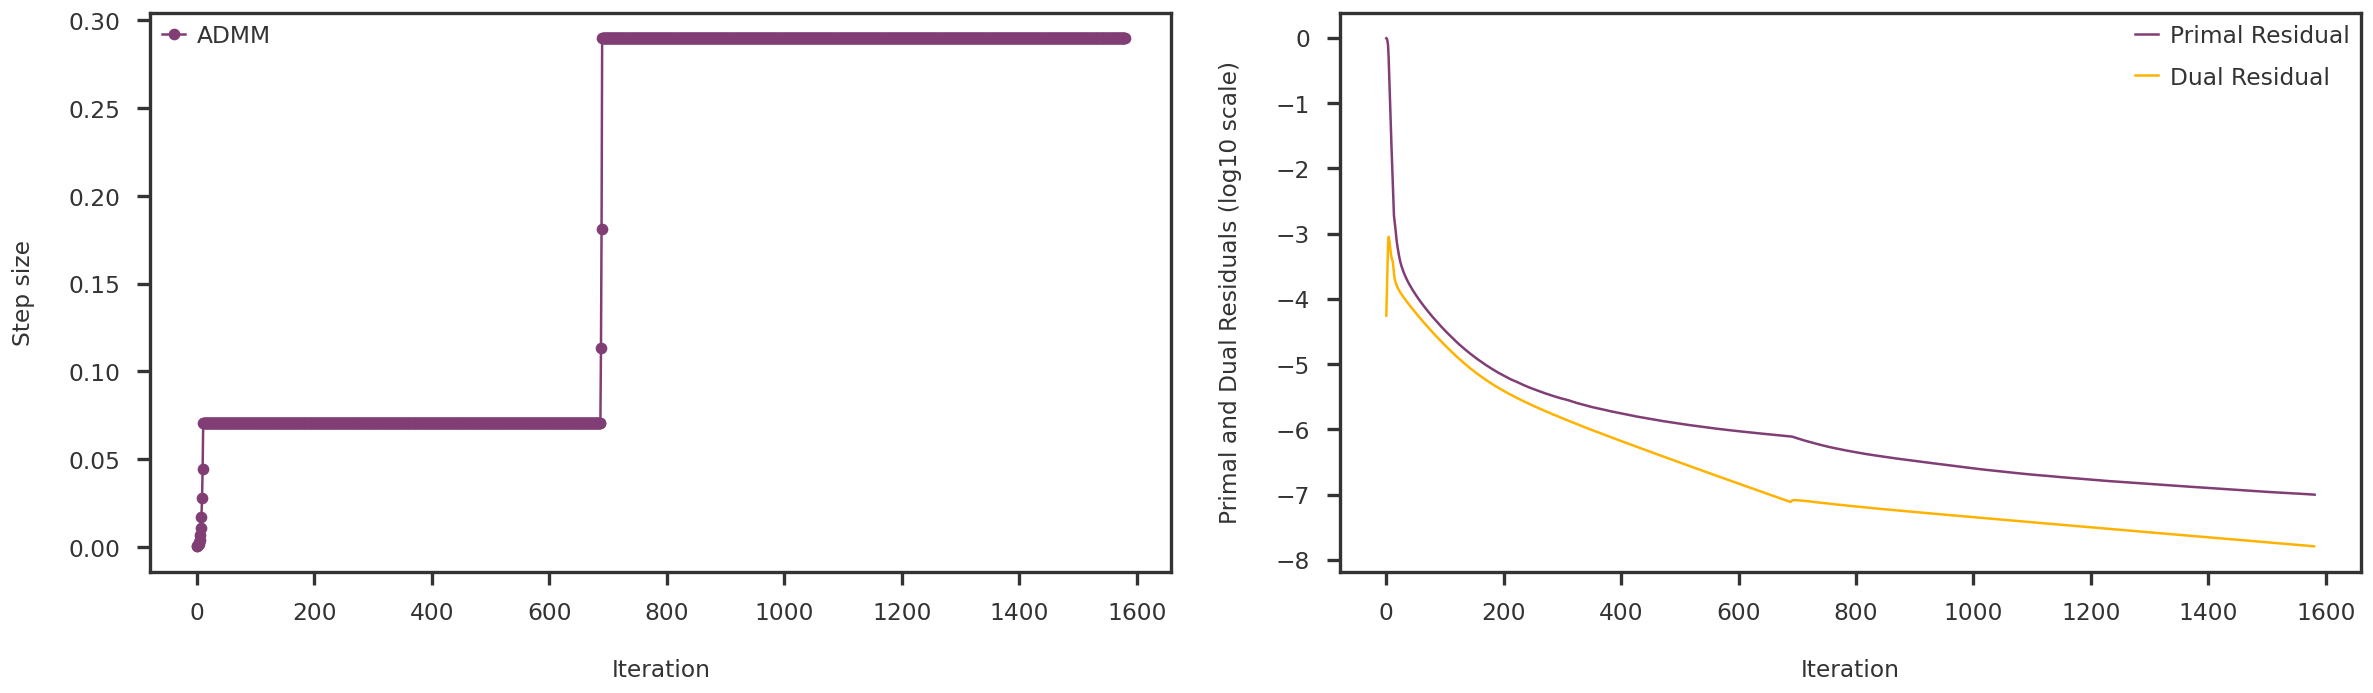

In [6]:
#| label: fig-ialm-convergence
#| fig-cap: "Convergence properties of Robust PCA using IALM."

fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(range(len(ialm['mu_list'])), ialm['mu_list'], 'o-', label = 'ADMM')
ax1.legend()
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Step size")

ax2.plot(range(len(ialm['primal_residual'])),   np.log10(ialm['primal_residual']),   label = 'Primal Residual')
ax2.plot(range(len(ialm['dual_residual']) - 1), np.log10(ialm['dual_residual'][1:]), label = 'Dual Residual')
ax2.legend()
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Primal and Dual Residuals (log10 scale)")

plt.tight_layout(w_pad = 2.0)
plt.show()

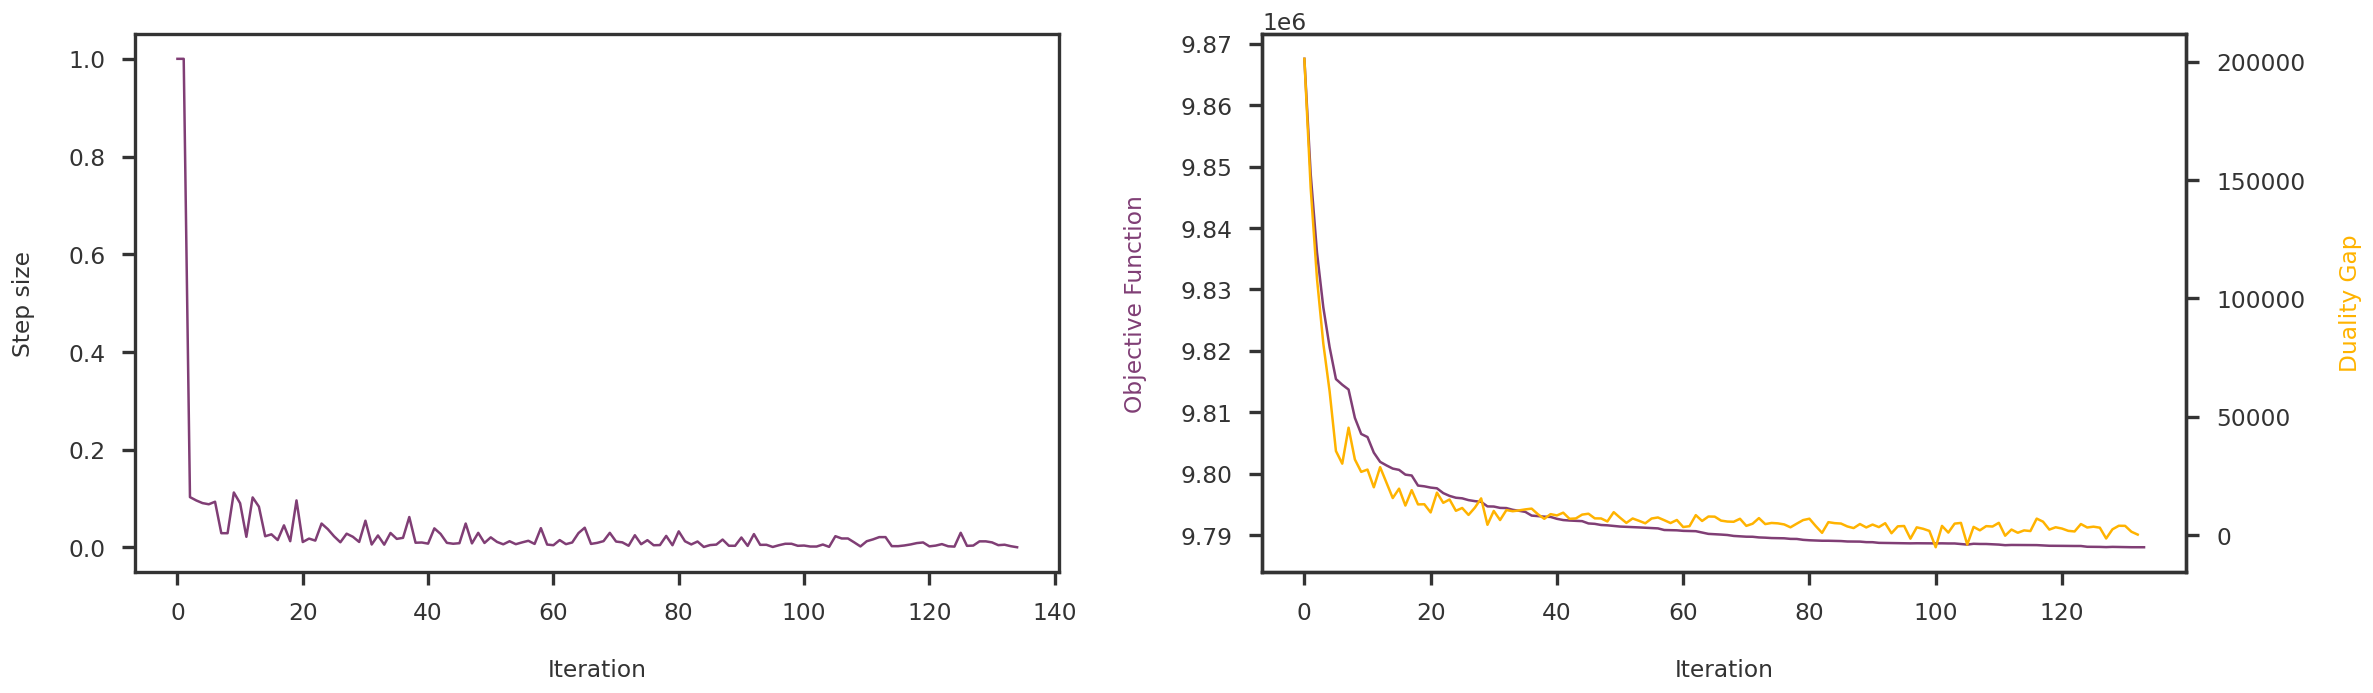

In [7]:
#| label: fig-nnmfw-sparse-convergence
#| fig-cap: "Convergence properties of sparse Nuclear Norm matrix factorization using Frank-Wolfe algorithm"

fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(range(len(nnm_sparse['steps'])), nnm_sparse['steps'])
# ax1.legend()
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Step size")

ax2b = ax2.twinx()
colors = mpl_stylesheet.kelly_colors()
#p1 = ax2.plot(range(len(nnm_sparse['objective']) - 2), - np.diff(nnm_sparse['objective'])[1:], 'o-', label = 'Objective', color = colors[0])
p1 = ax2.plot(range(len(nnm_sparse['objective']) - 1), nnm_sparse['objective'][1:], label = 'Objective', color = colors[0])
p2 = ax2b.plot(range(len(nnm_sparse['duality_gap']) - 2), nnm_sparse['duality_gap'][2:], label = 'Duality Gap', color = colors[1])

ax2.set_xlabel("Iteration")
ax2.set_ylabel("Objective Function")
ax2.yaxis.label.set_color(p1[0].get_color())
ax2b.set_ylabel("Duality Gap")
ax2b.yaxis.label.set_color(p2[0].get_color())

plt.tight_layout(w_pad = 2.0)
plt.show()

# PCA of Low Rank Matrix

In [8]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps, S

lowrank_X = dict()
loadings  = dict()
pcomps    = dict()
eigenvals = dict()

for m in mf_methods:
    if m != 'tsvd':
        with open (f"{result_dir}/{method_prefix[m]}_lowrank_X.pkl", 'rb') as handle:
            lowrank_X[m] = pickle.load(handle)
lowrank_X['tsvd'] = X_cent.copy()
for m in mf_methods:
    loadings[m], pcomps[m], eigenvals[m] = get_principal_components(lowrank_X[m])

In [11]:
trait_df_mod['trait_type'].value_counts()

trait_type
continuous       776
phecode          662
icd10            375
prescriptions    373
categorical      267
biomarkers        30
Name: count, dtype: int64

# Nuclear Norm of Low Rank Matrix

In [12]:
for m in mf_methods:
    print (f"{method_names[m]}: {np.linalg.norm(lowrank_X[m], 'nuc'):g}")

RPCA-IALM: 180216
NNM-Sparse: 1023.04
Raw Data: 495872


# L0 norm of error matrix

In [13]:
lowrank_E = dict()
for m in mf_methods:
    if m != 'tsvd':
        with open (f"{result_dir}/{method_prefix[m]}_lowrank_E.pkl", 'rb') as handle:
            lowrank_E[m] = pickle.load(handle)

In [14]:
for m in mf_methods:
    if m != 'tsvd':
        print (f"{method_names[m]}: {np.linalg.norm(lowrank_E[m], ord = 1):g}")
    else:
        print (f"{method_names[m]}: {np.linalg.norm(lowrank_X[m], ord = 1):g}")

RPCA-IALM: 2003.58
NNM-Sparse: 3491.56
Raw Data: 4527.88


# Plots for Principal Components (Hidden Factors)

In the following figures, we look at the first few principal components (hidden factors)
obtained by applying PCA on the predicted low-rank matrices.
The samples are colored using the six trait types for the [Pan-UKB project](https://pan-dev.ukbb.broadinstitute.org/docs/per-phenotype-files/index.html).
They are:
  - **continuous**: Quantitative traits obtained from questionnaires and assessment centers, e.g. standing height, distance between home and job workplace, etc.
  - **biomarkers**: Obtained from biological samples, e.g. cholesterol, triglycerides.
  - **prescriptions**: Varied treatment/medication/prescriptions, e.g. amoxicillin, corticosteroids, etc.
  - **icd10**: Set of ICD10 codes
  - **phecode**: PHESANT software? Manually curated by FinnGen?
  - **categorical**: Categorical traits obtained from questionnaires and assessment centers, e.g. different self-reported illness, COVID-19, self-reported treatment/medication, etc.

In [15]:
trait_types  = trait_df_mod['trait_type'].unique().tolist()
trait_colors = {trait: color for trait, color in zip(trait_types, mpl_stylesheet.kelly_colors()[:len(trait_types)])}
trait_types.reverse()

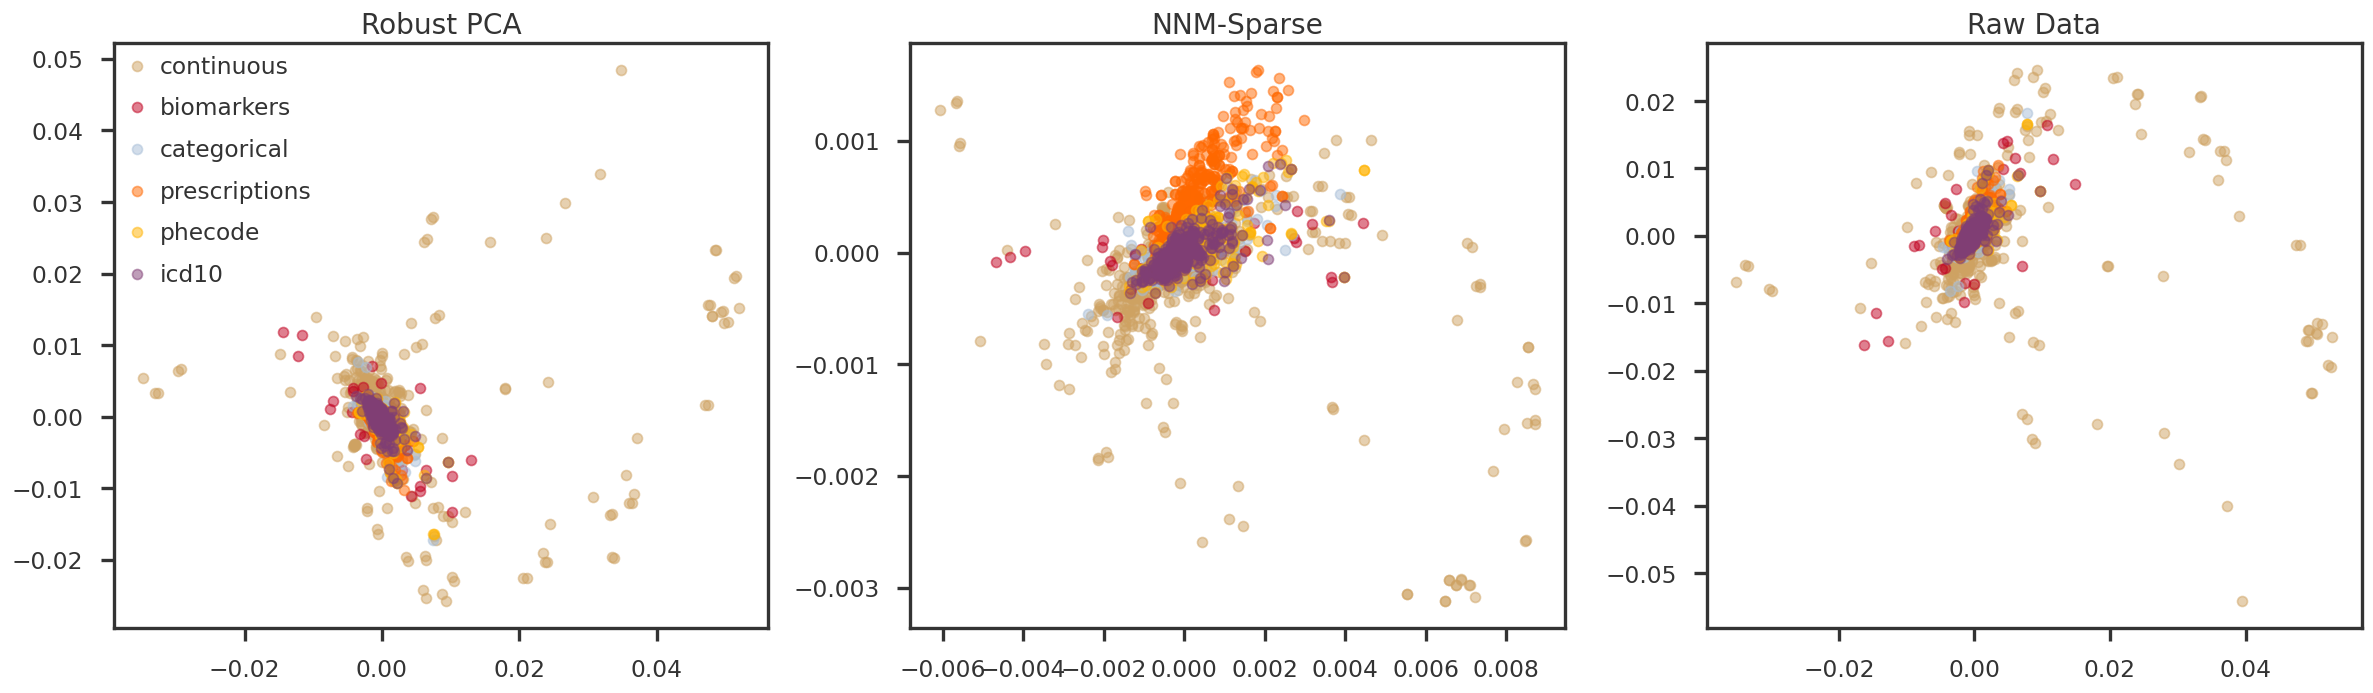

In [18]:
#| label: fig-pcomps-0-1
#| fig-cap: "PC1 vs PC2"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 0
ipc2 = 1

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

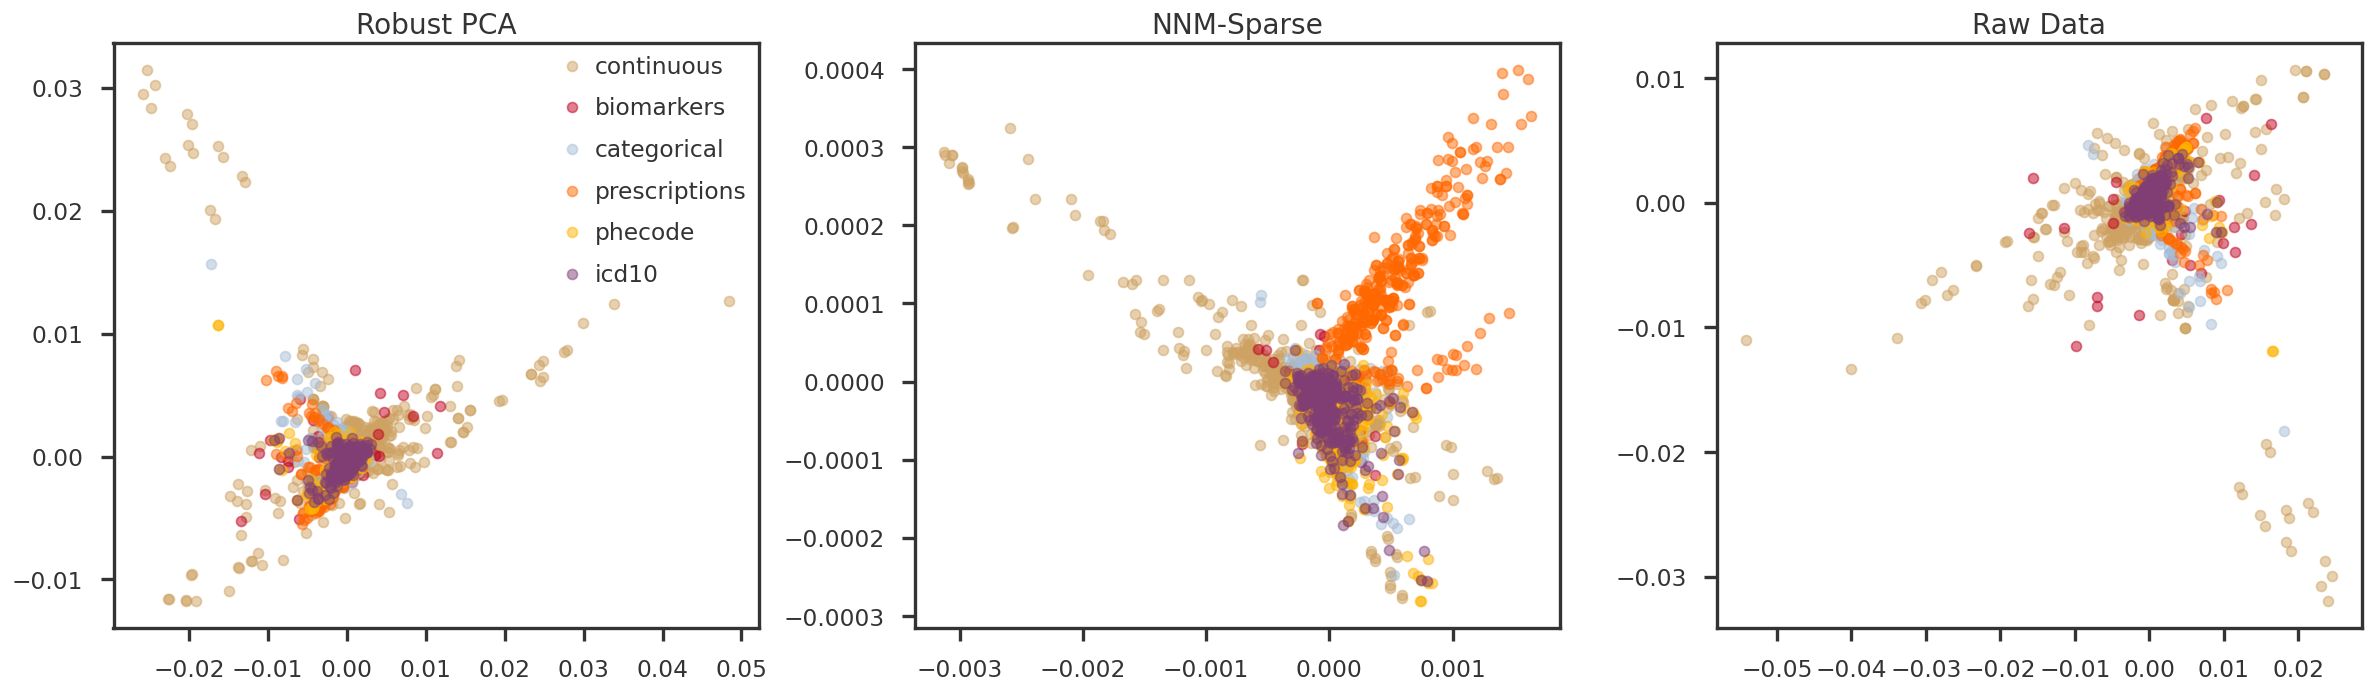

In [19]:
#| label: fig-pcomps-1-2
#| fig-cap: "PC2 vs PC3"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 1
ipc2 = 2

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

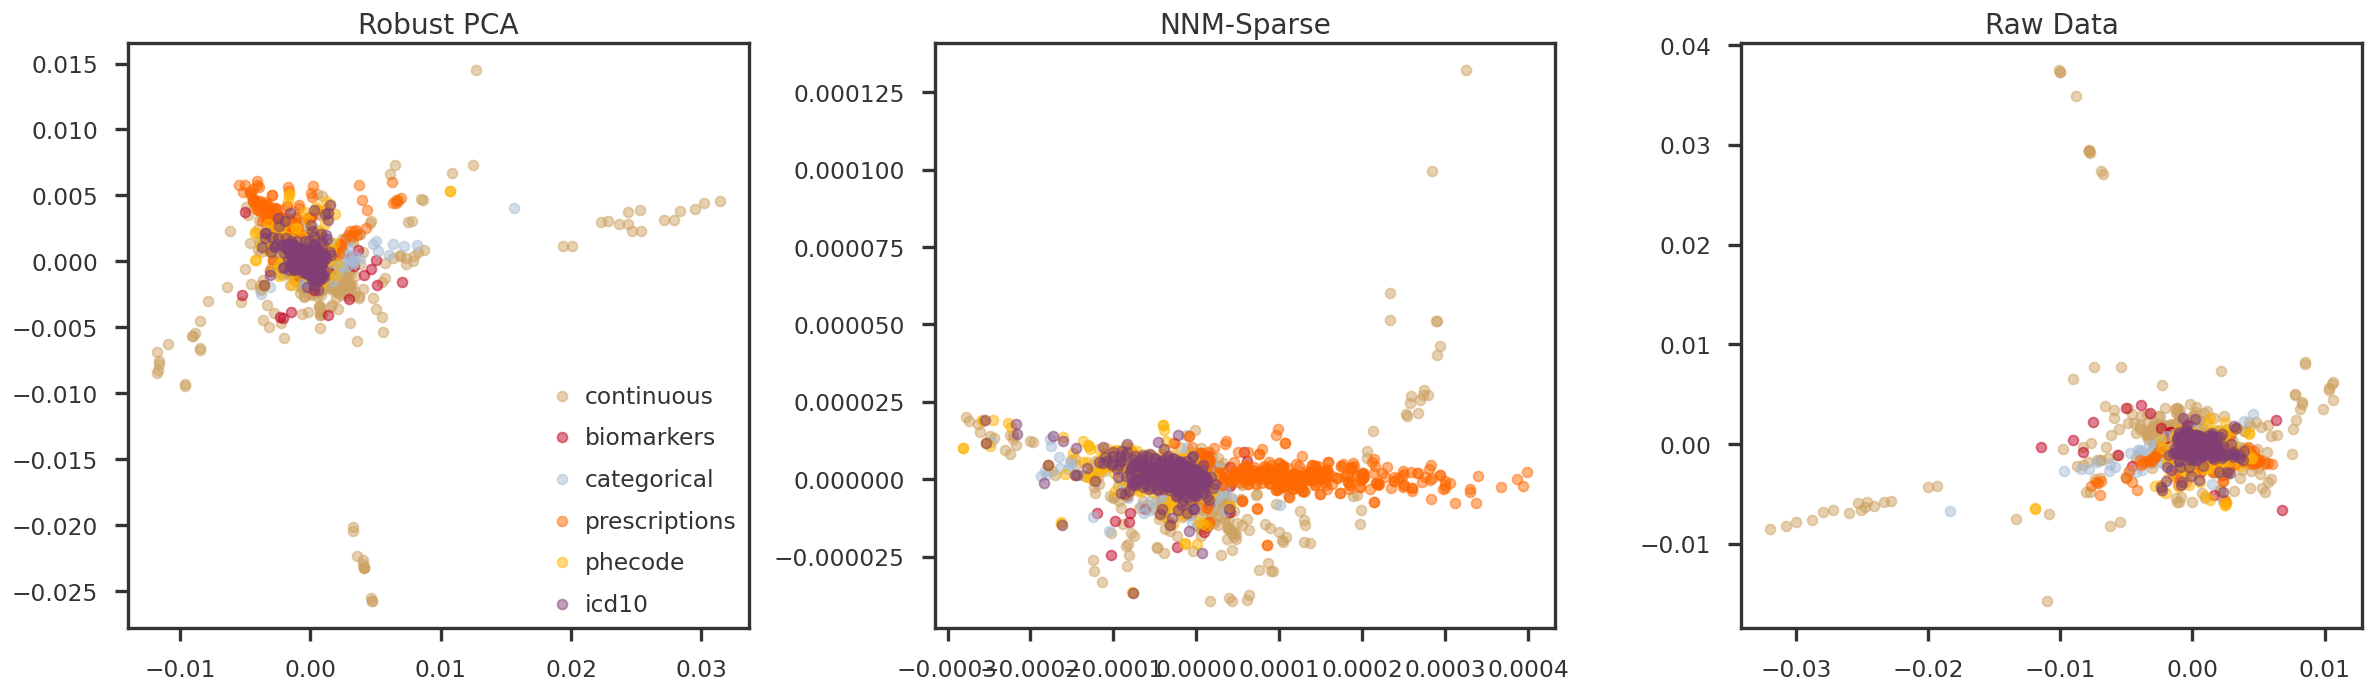

In [20]:
#| label: fig-pcomps-2-3
#| fig-cap: "PC3 vs PC4"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 2
ipc2 = 3

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

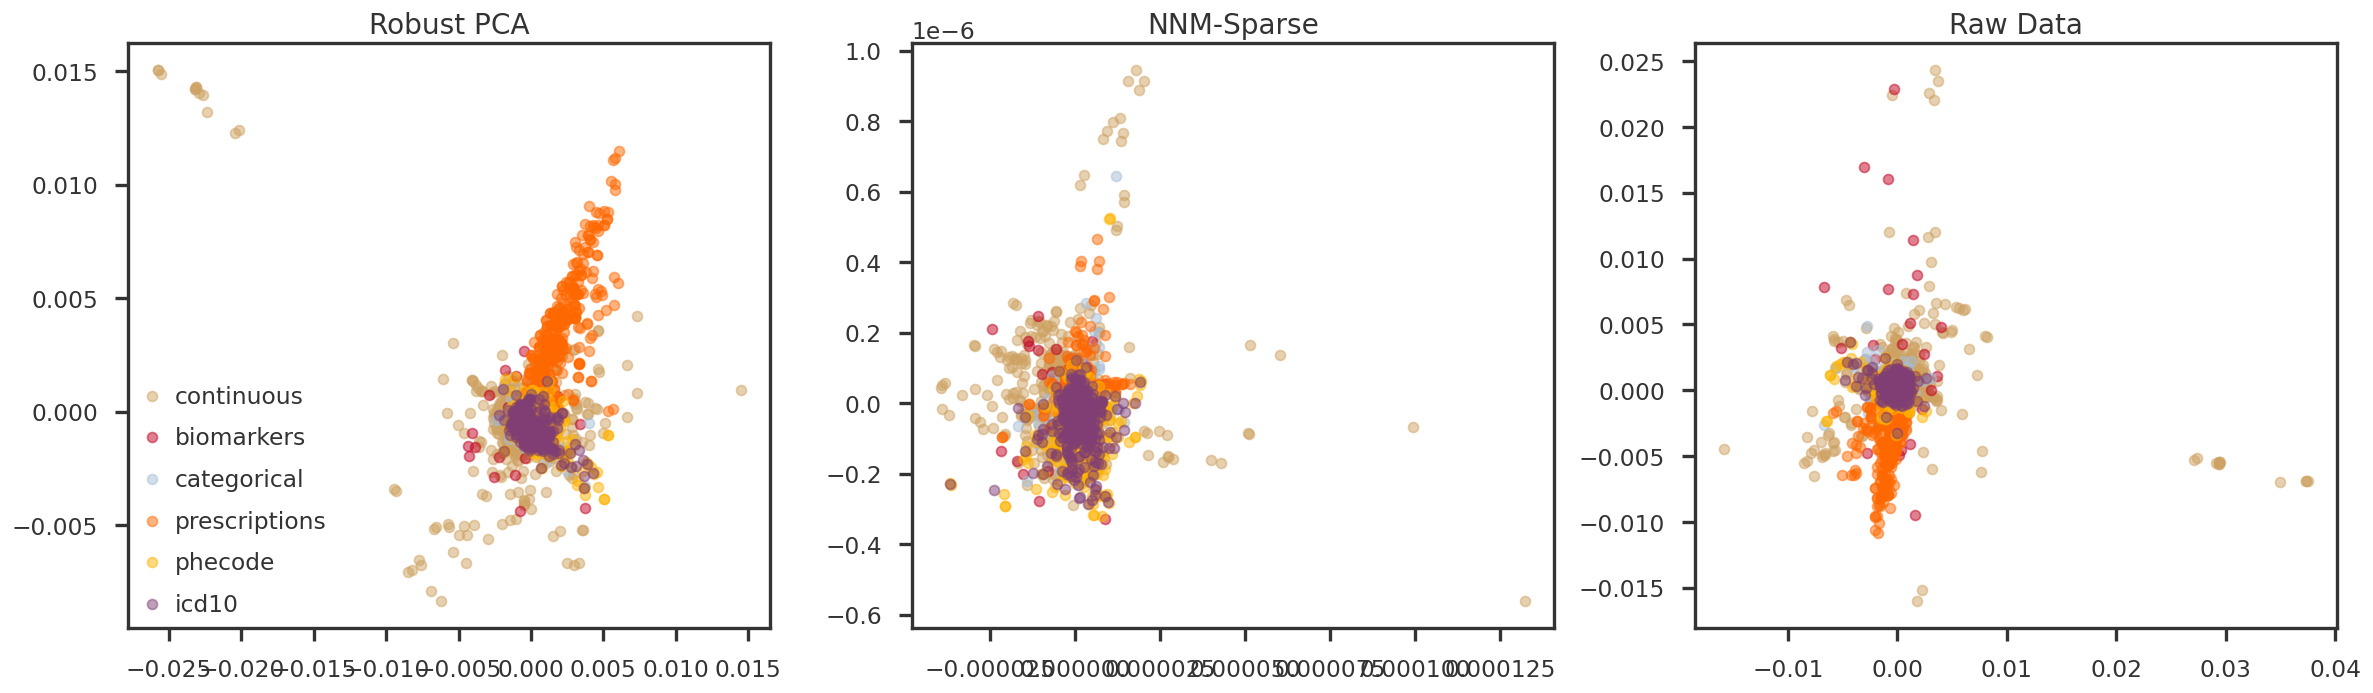

In [21]:
#| label: fig-pcomps-3-4
#| fig-cap: "PC4 vs PC5"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 3
ipc2 = 4

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

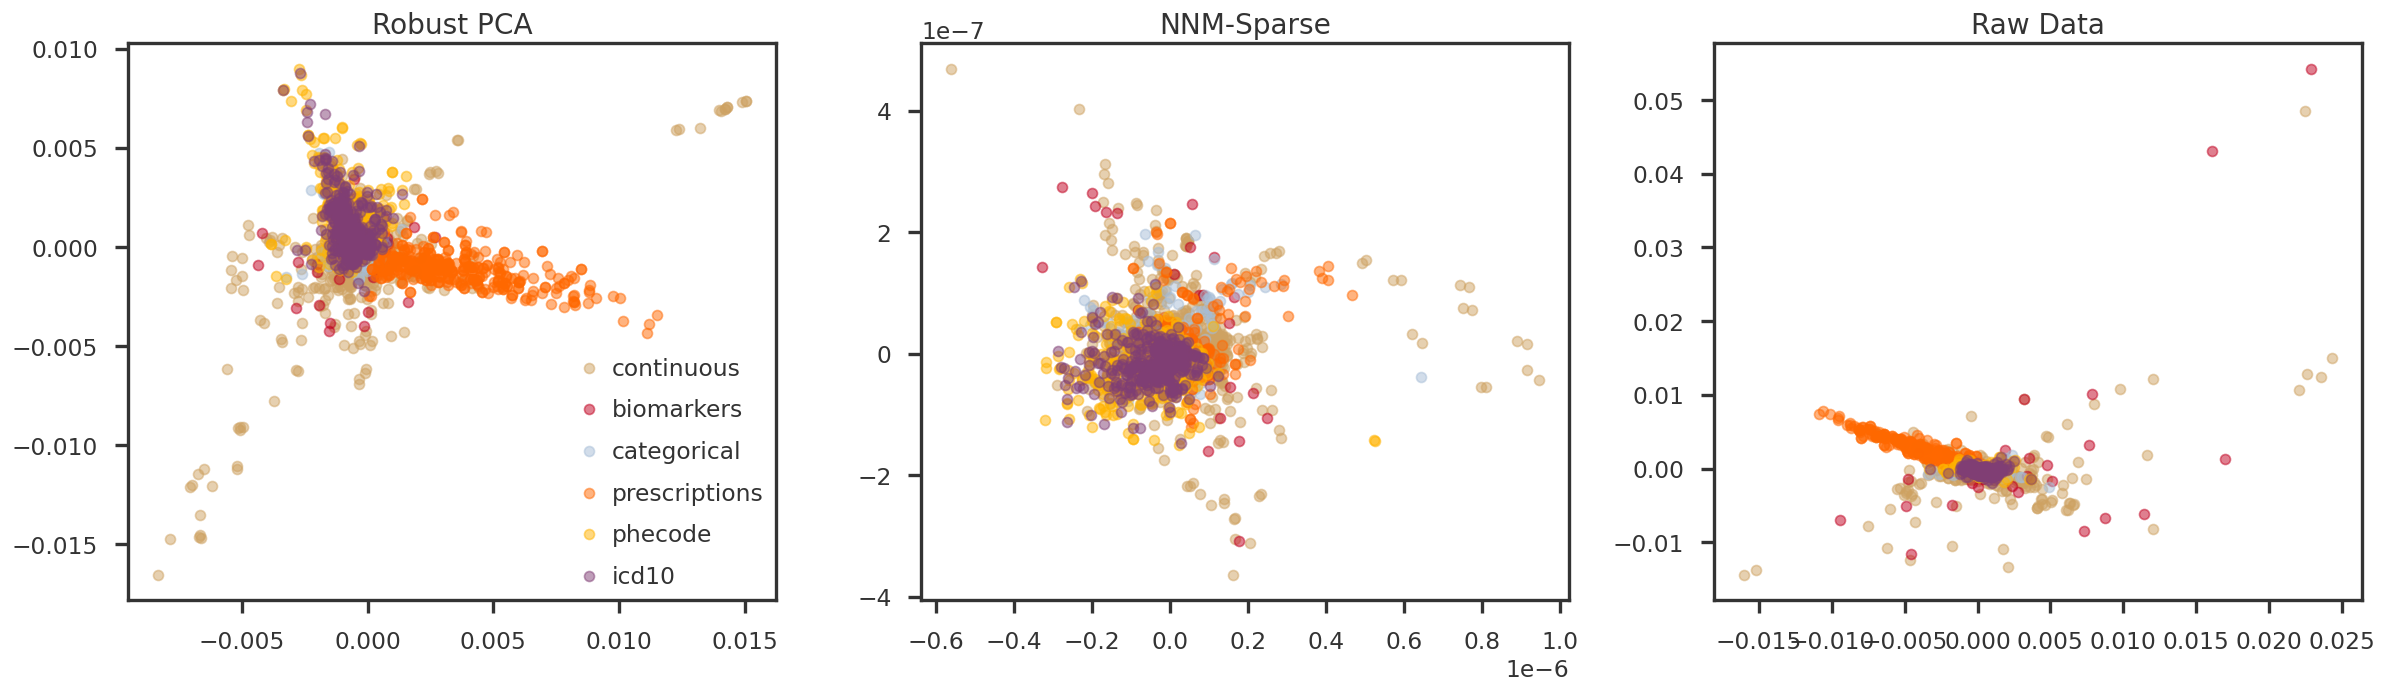

In [22]:
#| label: fig-pcomps-4-5
#| fig-cap: "PC5 vs PC6"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 4
ipc2 = 5

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

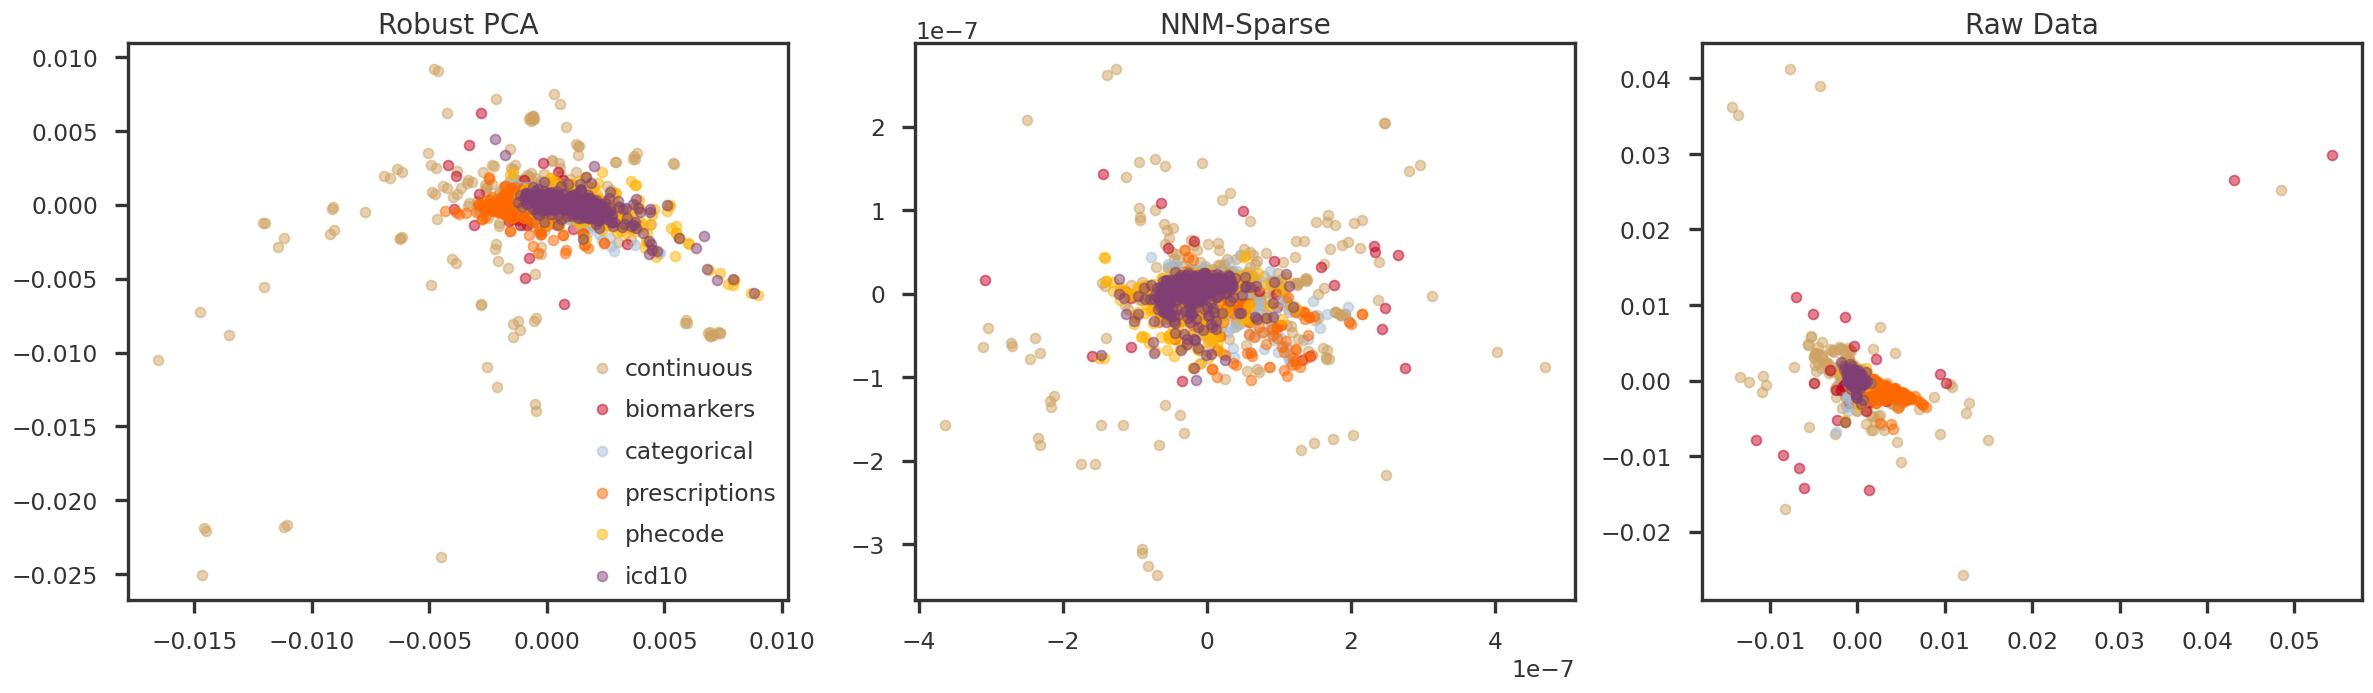

In [23]:
#| label: fig-pcomps-5-6
#| fig-cap: "PC6 vs PC7"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 5
ipc2 = 6

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

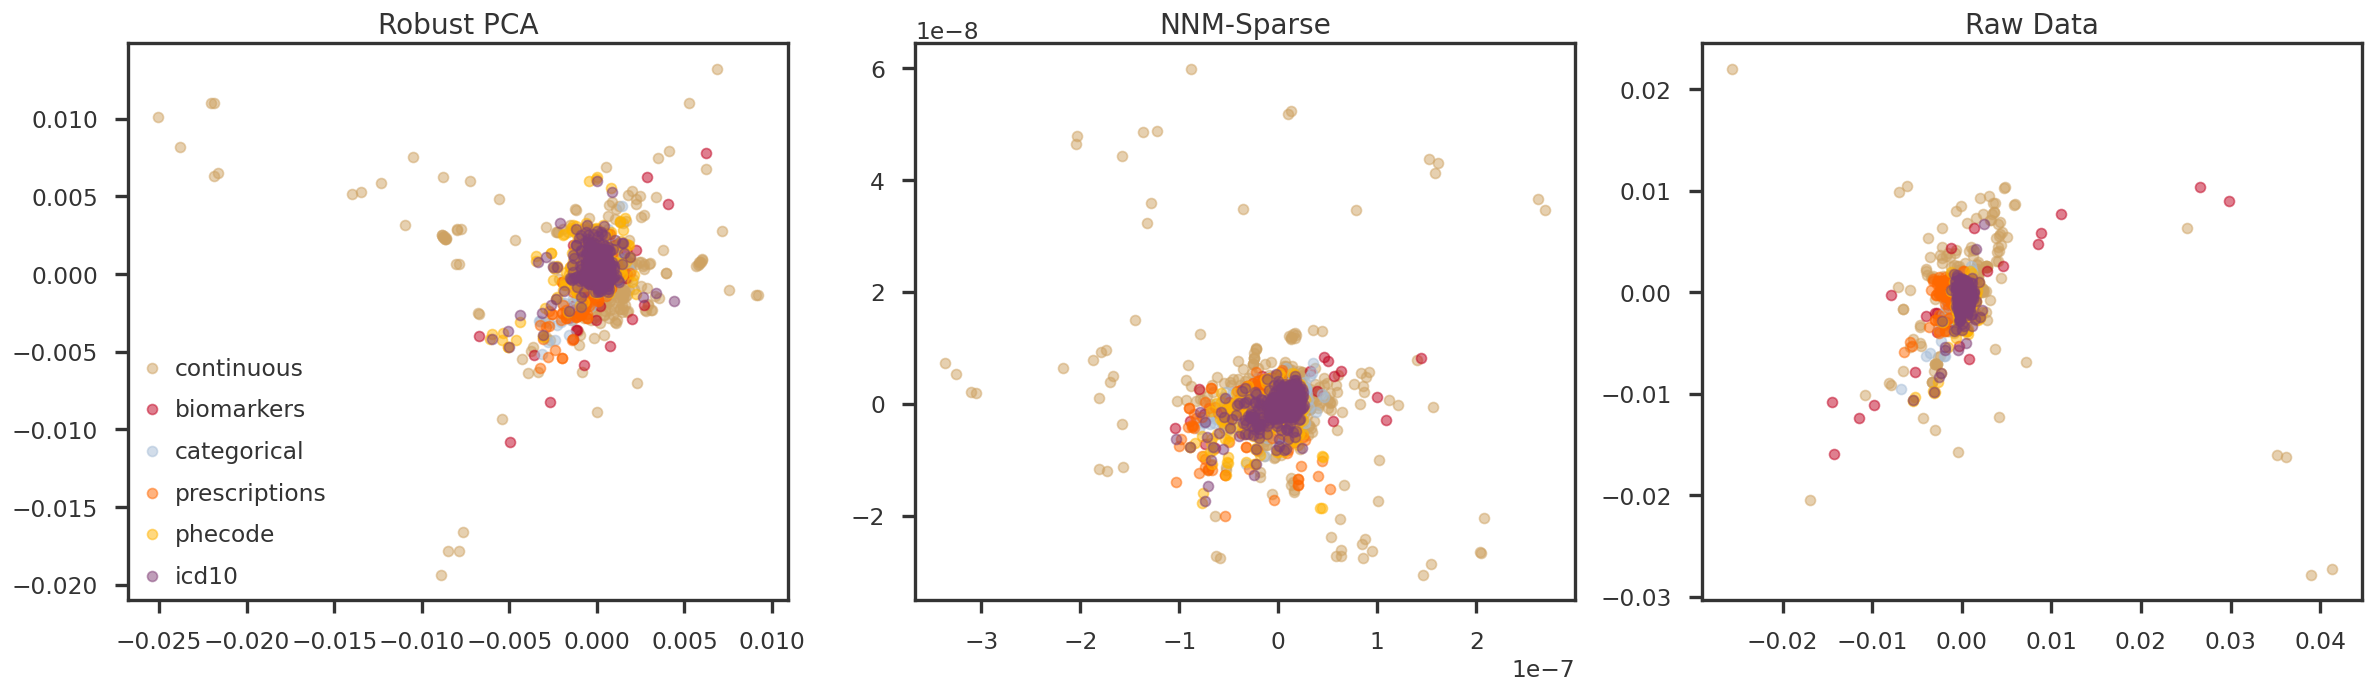

In [24]:
#| label: fig-pcomps-6-7
#| fig-cap: "PC7 vs PC8"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 6
ipc2 = 7

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

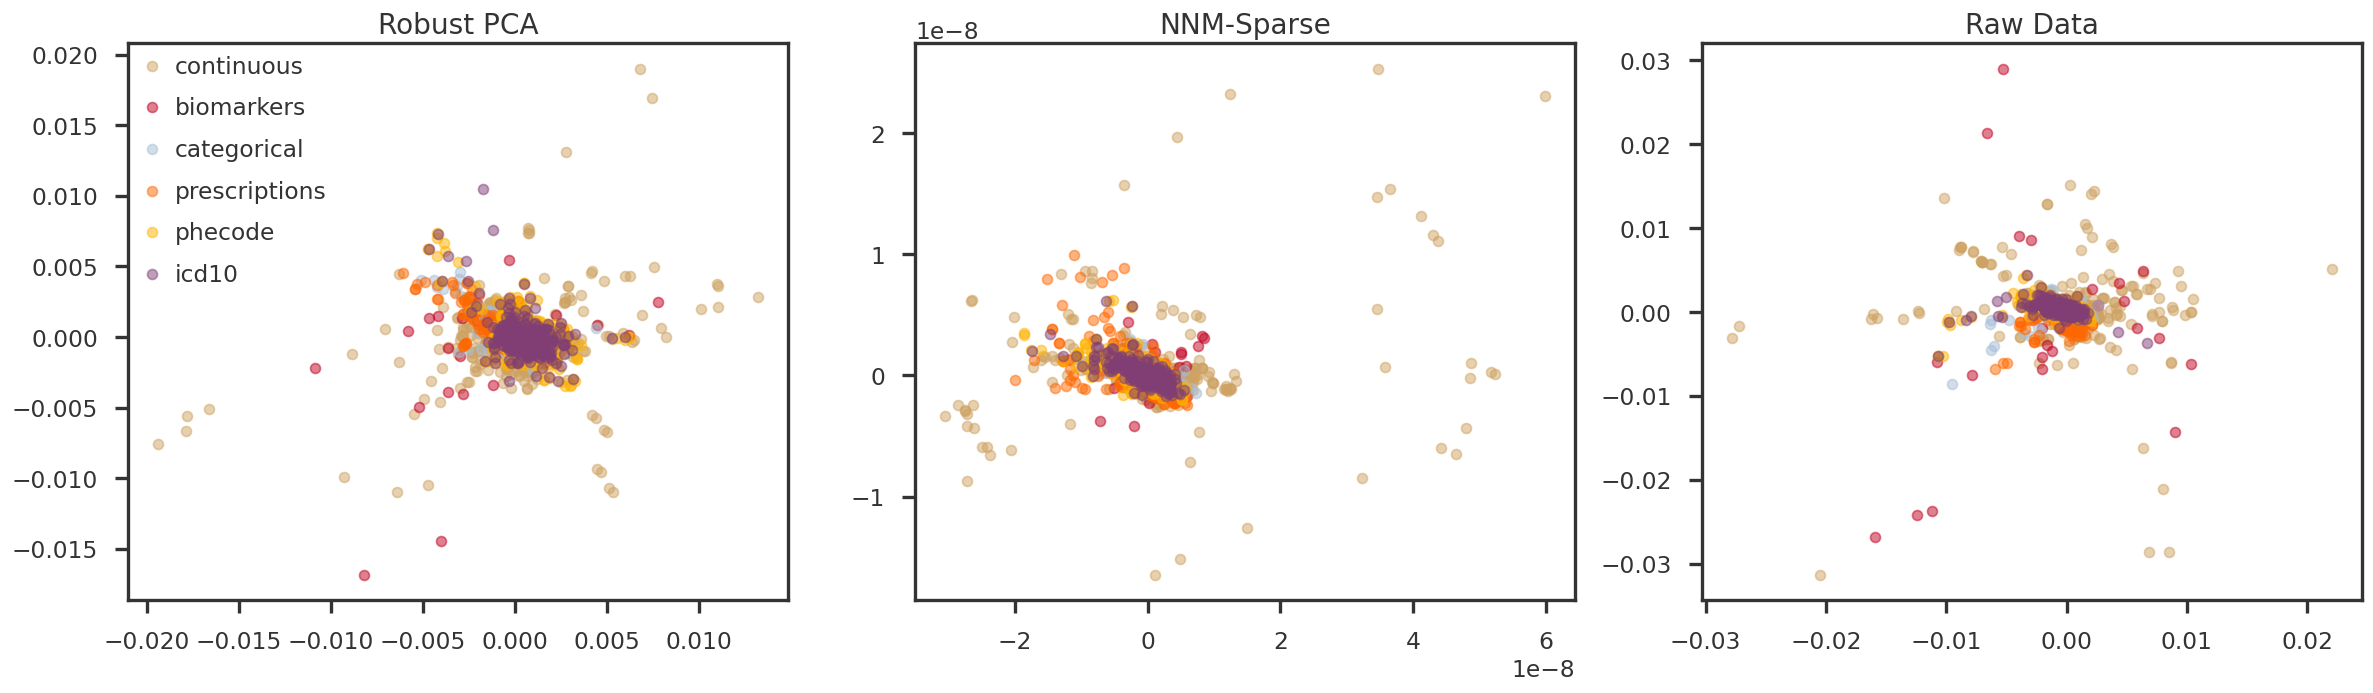

In [25]:
#| label: fig-pcomps-7-8
#| fig-cap: "PC8 vs PC9"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 7
ipc2 = 8

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()

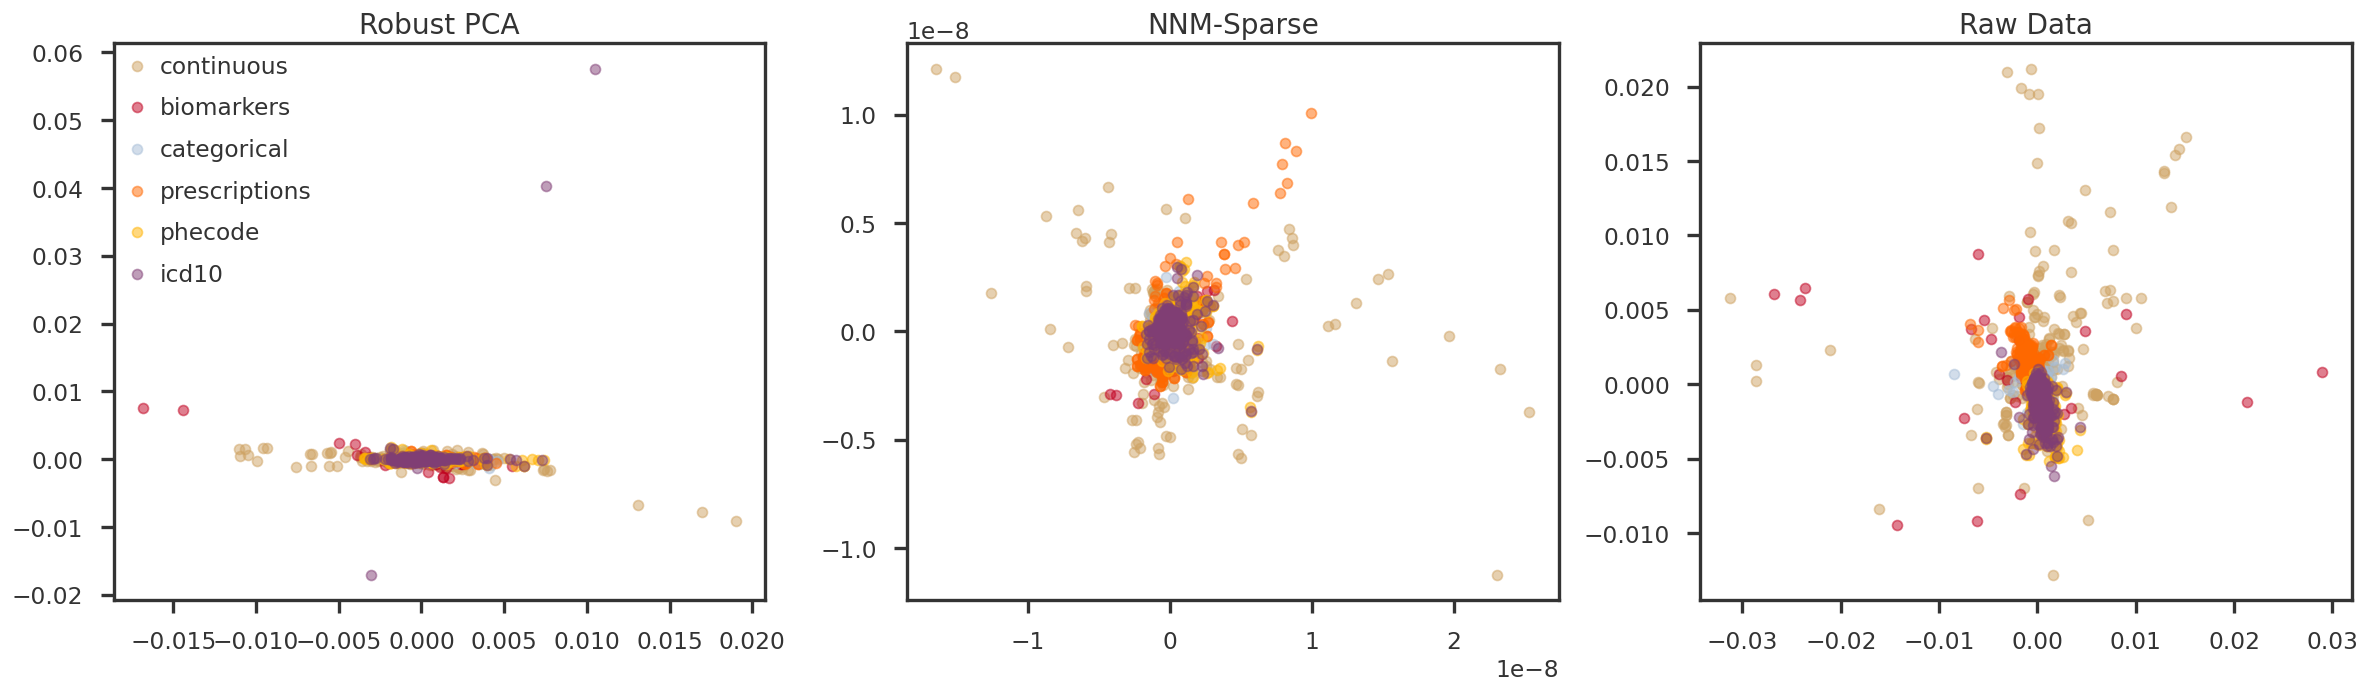

In [26]:
#| label: fig-pcomps-8-9
#| fig-cap: "PC9 vs PC10"

fig = plt.figure(figsize = (20, 6))
ax = [None for m in mf_methods]

ipc1 = 8
ipc2 = 9

for i, m in enumerate(mf_methods):
    ax[i] = fig.add_subplot(1, 3, i+1)
    for t in trait_types:
        tidx = np.array(trait_df_mod[trait_df_mod['trait_type'] == t].index)
        ax[i].scatter(pcomps[m][tidx, ipc1], pcomps[m][tidx, ipc2], alpha = 0.5, color = trait_colors[t], label = t)
    ax[i].set_title(method_names[m])
    if i == 0:
        ax[i].legend()
    
plt.tight_layout(h_pad = 2.0)
plt.show()